In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D

In [3]:
curr_path = os.getcwd()
input_path = os.path.join(curr_path,'merged_data_1020.xlsx')

data = pd.read_excel(
    input_path,
    engine='openpyxl',
)
data.drop(['ManufacturingNewOrders','ConstructionSpending'], axis=1, inplace=True)
data.dropna(inplace = True)

In [4]:
withouty = data.iloc[:, 2:]
withouty
normalizeddata = (withouty - withouty.mean()) / withouty.std()
normalizeddata['SP500-EPS-Index'] = data['SP500-EPS-Index']

In [5]:
data

,Date,SP500-Price,SP500-EPS-Index,gdp,IndustrialProduction,GS10,CPIFABSL,MedianUsualWeeklyRealEarnings,PCE,PPI,VolumeOfTotalRetailTradeSales-GR,HousingSales,UnemploymentRate,EffectiveRate,M2,GovernmentBudgetBalance
114,1979-02-01,98.23,221.000849,2591.247,47.5167,9.10,77.700,335.0,1517.8,74.9,57.855746,61200,5.9,10.06,1369.3,21.379
115,1979-03-01,100.10,226.404356,2591.247,47.7473,9.12,78.400,335.0,1531.2,75.8,58.420256,60400,5.8,10.09,1384.0,21.379
116,1979-04-01,102.10,230.316190,2591.247,46.9632,9.18,78.900,335.0,1538.4,76.9,57.656483,62600,5.8,10.01,1408.4,21.379
117,1979-05-01,99.73,234.279069,2667.565,47.5953,9.25,79.700,330.0,1558.8,77.5,57.579018,62800,5.6,10.24,1402.7,-4.482
118,1979-06-01,101.70,238.249622,2667.565,47.6561,8.91,80.000,330.0,1575.7,78.0,57.371615,64200,5.7,10.29,1422.5,-4.482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,2019-06-01,2890.17,2303.374446,21505.012,99.6115,2.07,257.707,360.0,14425.7,200.3,106.099185,311800,3.6,2.38,14753.8,-237.915
599,2019-07-01,2996.11,2290.278233,21505.012,99.2139,2.06,257.998,360.0,14487.4,200.7,106.615519,308300,3.6,2.40,14833.1,-237.915
600,2019-08-01,2897.50,2277.247380,21694.458,99.7598,1.63,258.158,362.0,14536.4,199.2,107.118994,327000,3.7,2.13,14914.7,-356.353
601,2019-09-01,2982.16,2263.360675,21694.458,99.1341,1.70,258.740,362.0,14564.7,198.4,106.090787,315700,3.5,2.04,15005.6,-356.353


In [6]:
# a helper function concats data among lagged window (length=lags) with the target
# e.g, for input dat with var = [date, X, y], lags = 2, 
#  the returned dataset will have colunn names [date_2, X_2, y_2, date_1, X_1, y_1, date, X, y] with length - 2

def flatten_data(dat, lags = 3):
    new_data = dat.copy(deep=False)

    # add variables you don't want to include below
    dropped_col = ['gdp']
    for i in range(dat.shape[1]):
        new_data.columns.values[i] = new_data.columns.values[i] + '_'  + str(0)
    
    #new_data.drop(dropped_col, axis=1, inplace=True)
    
    for n in range(lags):
        fill_data = dat.shift(periods = n+1)
        fill_data = fill_data.iloc[n+1: , :]
        new_data = new_data.iloc[1:, :]
        new_data = pd.concat([fill_data, new_data], axis=1)
        
        # rename added columns
        for i in range(dat.shape[1]):
            new_data.columns.values[i] = dat.columns.values[i][:-2] + '_'  + str(n+1)
        new_dropped_col=[]
        for i in range(len(dropped_col)):
            name = dropped_col[i]+'_'+str(n+1)
            new_dropped_col.append(name)
        new_data.drop(new_dropped_col, axis=1, inplace=True)
            
    return new_data

In [7]:
lags=15
flatterned = flatten_data(normalizeddata, lags = lags)

In [8]:
flatterned.drop(['gdp_0'], axis = 1, inplace = True)

In [9]:
flatterned.shape
n_features = int(flatterned.shape[1]/(lags+1))

In [10]:
# train ratio = 0.8
def train_test_split(data, ratio):
    n = len(data)
    train_idx = round(n*ratio) +1
    test_idx = round(n*ratio) + 1
    train = data[:train_idx]
    test = data[test_idx:]
    # find train_y, train_x and test_y, test_x
    train_y = train['SP500-EPS-Index_0']
    train_x = train.loc[:, data.columns[:int(n_features*lags)]]
    test_y = test['SP500-EPS-Index_0']
    test_x = test.loc[:, data.columns[:int(n_features*lags)]]
    return train_y, test_y, train_x, test_x

In [11]:
train_y, test_y, train_x, test_x = train_test_split(flatterned, 0.97)

In [12]:
# reshape data and normalize data
train_x = np.array(train_x).reshape(len(train_x), lags, n_features, 1)
test_x = np.array(test_x).reshape(len(test_x), lags, n_features, 1)

In [13]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

# build CNN model
model = Sequential()
model.add(Conv2D(filters = 32, 
                 input_shape = ((lags,n_features,1)),
                 data_format = 'channels_last',
                 kernel_size=(2,2), 
                 strides=(1,1),   
                 activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 1)))
#model.add(AveragePooling2D(pool_size=(2,1)))
model.add(Flatten())
model.add(Dense(45, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss=root_mean_squared_error)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 12, 32)        160       
_________________________________________________________________
flatten (Flatten)            (None, 5376)              0         
_________________________________________________________________
dense (Dense)                (None, 45)                241965    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46        
Total params: 242,171
Trainable params: 242,171
Non-trainable params: 0
_________________________________________________________________


In [14]:
result = model.fit(train_x, train_y, verbose=1, validation_data=(test_x, test_y), epochs=20)

Epoch 1/20
15/15 [==============================] - 0s 6ms/step - loss: 321.3477 - val_loss: 81.5321
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 113.3270 - val_loss: 139.4693
Epoch 3/20
15/15 [==============================] - 0s 2ms/step - loss: 93.5881 - val_loss: 64.6661
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 83.3672 - val_loss: 71.7643
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 71.5713 - val_loss: 80.4455
Epoch 6/20
15/15 [==============================] - 0s 2ms/step - loss: 62.7998 - val_loss: 72.9734
Epoch 7/20
15/15 [==============================] - 0s 2ms/step - loss: 50.4673 - val_loss: 32.3793
Epoch 8/20
15/15 [==============================] - 0s 2ms/step - loss: 43.8224 - val_loss: 23.6281
Epoch 9/20
15/15 [==============================] - 0s 2ms/step - loss: 40.1733 - val_loss: 31.7895
Epoch 10/20
15/15 [==============================] - 0s 2ms/step - loss: 39.8049 - val_loss: 79.3

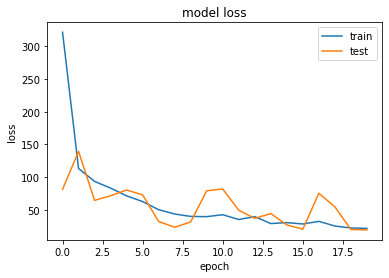

In [15]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')


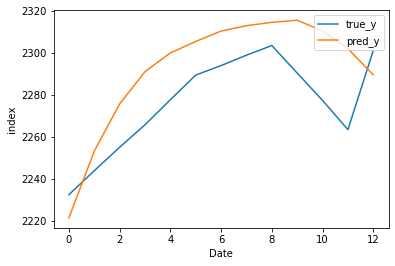

In [16]:
f, ax = plt.subplots()
ax.plot(test_y.values)
ax.plot(model.predict(test_x))
ax.set_ylabel('index')
ax.set_xlabel('Date')
ax.legend(['true_y', 'pred_y'], loc='upper right')

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(model.predict(test_x), test_y.values, squared=False)

21.401846175803975